In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='INFO')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

2021-04-11 12:14:05,227 - PySpice.Spice.Parser.SpiceParser._parse - WARNING - Parser ignored: .PARAM VCC_ABS_MAX = 20 
2021-04-11 12:14:05,228 - PySpice.Spice.Parser.SpiceParser._parse - WARNING - Parser ignored: .PARAM VCC_MAX = 18 
2021-04-11 12:14:05,229 - PySpice.Spice.Parser.SpiceParser._parse - WARNING - Parser ignored: .PARAM RA = 720000000 
2021-04-11 12:14:05,229 - PySpice.Spice.Parser.SpiceParser._parse - WARNING - Parser ignored: .PARAM RB = 720000000 
2021-04-11 12:14:05,230 - PySpice.Spice.Parser.SpiceParser._parse - WARNING - Parser ignored: .PARAM CA = 4.5e-12 
2021-04-11 12:14:05,230 - PySpice.Spice.Parser.SpiceParser._parse - WARNING - Parser ignored: .PARAM CB = 4.5e-12 
2021-04-11 12:14:05,231 - PySpice.Spice.Parser.SpiceParser._parse - WARNING - Parser ignored: .PARAM ROEZ = 2000 
2021-04-11 12:14:05,239 - PySpice.Spice.Parser.SpiceParser._parse - WARNING - Parser ignored: .PARAM COEZ = 3e-12 
2021-04-11 12:14:05,241 - PySpice.Spice.Parser.Element.read_words - WARNI

The CD4069UB device consist of six CMOS inverter circuits. These devices are intended for all generalpurpose inverter applications where the mediumpower TTL-drive and logic-level-conversion. This device is not ideal for linear amplification, but can be used as such and will add a lot of soft-clipping. Soft-clipping is expected from a valve. This makes this device special for musical usage and can be found in guitar distortion pedals [[2](http://www.runoffgroove.com/ubescreamer.html)] or the wasp filter [[3](https://www.schmitzbits.de/wasp.html)]. 
{: class="mt-6"}

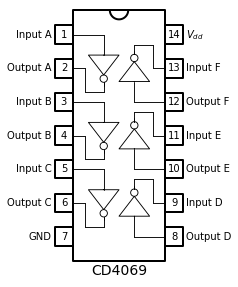

In [2]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)
d += (Q := elm.IcDIP(pins=14, botlabel='CD4069', lw=2)
             .label('Input A', loc='p1', fontsize=10)
             .label('Output A', loc='p2', fontsize=10)
             .label('Input B', loc='p3', fontsize=10)
             .label('Output B', loc='p4', fontsize=10)
             .label('Input C', loc='p5', fontsize=10)
             .label('Output C', loc='p6', fontsize=10)
             .label('GND', loc='p7', fontsize=10)

             .label('Output D', loc='p8', fontsize=10)
             .label('Input D', loc='p9', fontsize=10)
             .label('Output E', loc='p10', fontsize=10)
             .label('Input E', loc='p11', fontsize=10)
             .label('Output F', loc='p12', fontsize=10)
             .label('Input F', loc='p13', fontsize=10)
             .label('$V_{dd}$', loc='p14', fontsize=10))

d += elm.Line().at(Q.p1_in).length(d.unit/2.5)
d += (op := logic.Not("down").anchor('start').scale(1).length(d.unit*0.75))
d += elm.Line("left").length(d.unit/4)
d += elm.Line("up").toy(Q.p2_in)
d += elm.Line("left").tox(Q.p2_in)

d += elm.Line("right").at(Q.p3_in).length(d.unit/2.5)
d += (op := logic.Not("down").anchor('start').scale(1).length(d.unit*0.75))
d += elm.Line("left").length(d.unit/4)
d += elm.Line("up").toy(Q.p4_in)
d += elm.Line("left").tox(Q.p4_in)

d += elm.Line("right").at(Q.p5_in).length(d.unit/2.5)
d += (op := logic.Not("down").anchor('start').scale(1).length(d.unit*0.75))
d += elm.Line("left").length(d.unit/4)
d += elm.Line("up").toy(Q.p6_in)
d += elm.Line("left").tox(Q.p6_in)

d += elm.Line("left").at(Q.p8_in).length(d.unit/2.5)
d += (op := logic.Not("up").anchor('start').scale(1).length(d.unit*0.75))
d += elm.Line("right").length(d.unit/4)
d += elm.Line("down").toy(Q.p9_in)
d += elm.Line("right").tox(Q.p9_in)

d += elm.Line("left").at(Q.p10_in).length(d.unit/2.5)
d += (op := logic.Not("up").anchor('start').scale(1).length(d.unit*0.75))
d += elm.Line("right").length(d.unit/4)
d += elm.Line("down").toy(Q.p11_in)
d += elm.Line("right").tox(Q.p11_in)

d += elm.Line("left").at(Q.p12_in).length(d.unit/2.5)
d += (op := logic.Not("up").anchor('start').scale(1).length(d.unit*0.75))
d += elm.Line("right").length(d.unit/4)
d += elm.Line("down").toy(Q.p13_in)
d += elm.Line("right").tox(Q.p13_in)

d.draw()

the chip should be powered by +5V/GND. With higher voltage the heat dissipation will be to big and the chip will be damaged. the chip is powered on pin 7 and 14 with +5V and Ground. the other pins can be used as amplifier. 

# triangle oszillator
{: class="subtitle is-lowercase"}

the simplest circuit to begin with is a voltage follower or buffer. the buffer confifuration looks similar to the opamp buffer. but there are some differences. the first important difference is that the feedback will also do the biasing of the input signal. when an ac signal is applied to the buffer the output will be a dc signal, as long as the chip is able to provide the needed biasing feedback. the gain can be calculated similar to the opamp configuration. but there will be less gain as we would excpect from the calculation. 

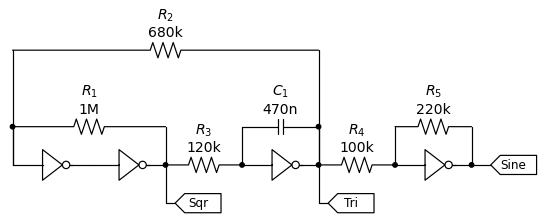

In [3]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=1.2)

N1 = d.add(logic.Not)
N2 = d.add(logic.Not)
d.add(elm.Resistor('right', label='$R_3$\n120k'))
d.add(elm.Dot())
N3 = d.add(logic.Not)
d.add(elm.Resistor('right', label='$R_4$\n100k'))
d.add(elm.Dot())
N4 = d.add(logic.Not)
d.add(elm.Line(l=d.unit/4))
d.add(elm.Tag(label="Sine"))

d.add(elm.Line('up', l=d.unit/2, at=N1.start))
d.add(elm.Dot())
d.add(elm.Resistor('right', label='$R_1$\n1M', tox=N2.end))
d.add(elm.Line('down', l=d.unit/2))
d.add(elm.Dot())

d.add(elm.Line('up', l=d.unit*1.5, at=N1.start))
d.add(elm.Resistor('right', label='$R_2$\n680k', tox=N3.end))
d.add(elm.Line('down', l=d.unit*1.5))

d.add(elm.Line('up', l=d.unit/2, at=N3.start))
d.add(elm.Capacitor("right", label='$C_1$\n470n', tox=N3.end))
d.add(elm.Dot())
d.add(elm.Line('down', l=d.unit/2))
d.add(elm.Dot())

d.add(elm.Line('up', l=d.unit/2, at=N4.start))
d.add(elm.Resistor('right', label='$R_5$\n220k', tox=N4.end))
d.add(elm.Line('down', l=d.unit/2))
d.add(elm.Dot())

d.add(elm.Line("Down", l=d.unit/2, at=N2.end))
d.add(elm.Line("right", l=d.unit/8))
d.add(elm.Tag(label="Sqr"))

d.add(elm.Line("Down", l=d.unit/2, at=N3.end))
d.add(elm.Line("right", l=d.unit/8))
d.add(elm.Tag(label="Tri"))

d.draw()

This is the first setup with the 4069 as voltage follower. C1 and C3 are the dc blocking capacitors. When we choose R1 and R2 as 100kOhm we would excpect a gain of one. 

In [4]:
Vp = (10000 + 22000) / 22000 * (5 / 2)
Vn = (10000 - 22000) / 22000 * (5 / 2)
print( 'lower switching point is %f and upper is %f' % (Vn, Vp))

lower switching point is -1.363636 and upper is 3.636364


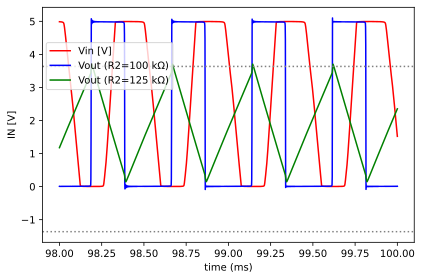

In [5]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')


circuit.X('1', '4069UB', 'X1i', 'X1o', '+5V', circuit.gnd)
circuit.X('2', '4069UB', 'X1o', 'X2o', '+5V', circuit.gnd)
circuit.R(3, 'X2o', 'X3i', 150@u_kΩ)
circuit.X('3', '4069UB', 'X3i', 'X3o', '+5V', circuit.gnd)
circuit.R(4, 'X3o', 'X4i', 100@u_kΩ)
circuit.X('4', '4069UB', 'X4i', 'X4o', '+5V', circuit.gnd)

circuit.R(1, 'X1i', 'X2o', 100@u_kΩ)
circuit.R(2, 'X1i', 'X3o', 47@u_kΩ)
circuit.R(5, 'X4i', 'X4o', 500@u_kΩ)
circuit.C(1, 'X3i', 'X3o', 1@u_nF)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis  = simulator.transient(step_time=1@u_us, start_time=98@u_ms, end_time=100@u_ms)

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
#ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
#buffer_axis, = ax1_buffer.plot(u_ms(analysis['X1i'].abscissa), analysis['X1i'], color='Orange')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['X4o'].abscissa), analysis['X4o'], color='Red')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['X2o'].abscissa), analysis['X2o'], color='Blue')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['X3o'].abscissa), analysis['X3o'], color='Green')
ax1_buffer.legend(('Vin [V]', 'Vout (R2=100 kΩ)', 'Vout (R2=125 kΩ)', 'Vout (R2=150 kΩ)', 'Vout (R2=200 kΩ)'), loc=(0.01,0.65))
ax1_buffer.axhline(y=Vp, color='Grey', linestyle='dotted')
ax1_buffer.axhline(y=Vn, color='Grey', linestyle='dotted')

plt.tight_layout()
plt.show()


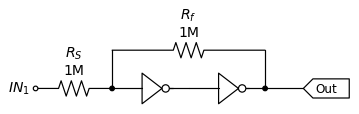

In [6]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=1.2)

d.add(elm.Dot('left', lftlabel='$IN_1$', open=True))
d.add(elm.Resistor('right', label='$R_S$\n1M'))
d.add(elm.Dot())
N1 = d.add(logic.Not)
N2 = d.add(logic.Not)
d.add(elm.Line(l=d.unit/2))
d.add(elm.Tag(label="Out"))

d.add(elm.Line('up', l=d.unit/2, at=N1.start))
d.add(elm.Resistor('right', label='$R_f$\n1M', tox=N2.end))
d.add(elm.Line('down', l=d.unit/2))
d.add(elm.Dot())

d.draw()

The blue line is the input signal (5V p2p) and the red the output signal with 100kOhm resistors. The output is a little less then excpected. For the other signals the resistor R2 is replaced with 125kΩ, 150kΩ, 175kΩ and 200kΩ. With 150kΩ the gain is roughly one. We also see that the ouput is not symetrical. The clipping occures earlier for the negative part of the signal. With higher gain the signal is soft clipped. 

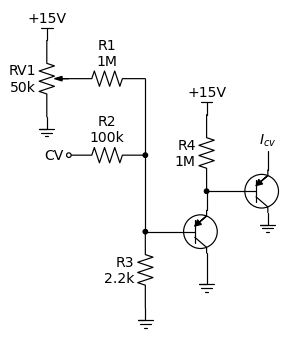

In [7]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=1.2)

P = d.add(elm.Potentiometer("down", toplabel="RV1\n50k"))
d.add(elm.Resistor("right", at=P.tap, label="R1\n1M"))
d.add(elm.Line("down"))
D1 = d.add(elm.Dot())

d.add(elm.Resistor("left", label="R2\n100k"))
d.add(elm.Dot(open=True, lftlabel="CV"))

d.add(elm.Vdd(label='+15V', at=P.start))
d.add(elm.Ground(at=P.end))

R3 = d.add(elm.Line("down", at=D1.start))
d.add(elm.Dot())
d.add(elm.Resistor("down", label='R3\n2.2k'))
d.add(elm.Ground)

d.add(elm.Line("right", l=d.unit/2, at=R3.end))
Q1 = d.add(elm.BjtPnp(circle=True))

d.add(elm.Line("down", l=d.unit/4, at=Q1.collector))
d.add(elm.Ground)

d.add(elm.Line("up", at=Q1.emitter, l=d.unit/4))
D2 = d.add(elm.Dot())
d.add(elm.Resistor("up", label='R4\n1M'))
d.add(elm.Vdd(label='+15V'))

d.add(elm.Line("right", at=D2.start, l=d.unit/2))
Q2 = d.add(elm.BjtPnp(circle=True))

d.add(elm.Line("up", at=Q2.emitter, rgtlabel="$I_{cv}$", l=d.unit/4))
d.add(elm.Ground(at=Q2.collector))

d.draw()

2021-04-11 12:14:09,247 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: v4: no DC value, transient time 0 value used


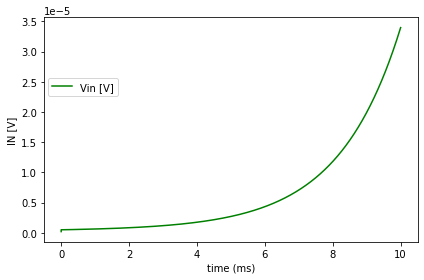

In [8]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])
circuit.include(spice_library['BC556B'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', '+15V', circuit.gnd, 'DC 15')
circuit.V('3', '-15V', circuit.gnd, 'DC -15')
circuit.V('4', 'CV', circuit.gnd, 'PULSE(10 0 0 10m)')
circuit.V('5', 'Icv', circuit.gnd, 'DC 1')
#circuit.I('input', 'Icv', circuit.gnd, 1@u_mA)

#expo converter
circuit.R(11, 'CV', 'R11', 100@u_kΩ)
circuit.R(13, 'R11', circuit.gnd, 1.5@u_kΩ)
circuit.BJT('1', '-15V', 'R11', 'Q1', model="BC556B")
circuit.R(14, 'Q1', "+15V", 1@u_MΩ)
circuit.BJT('2', circuit.gnd, 'Q1', 'Icv', model="BC556B")

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('savecurrents')

analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=10@u_ms)

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
#buffer_axis, = ax1_buffer.plot(u_ms(analysis['CV'].abscissa), analysis['CV'], color='Red')
#buffer_axis, = ax1_buffer.plot(u_ms(analysis['Icv'].abscissa), u_mA(-analysis.V5), color='Blue')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['Icv'].abscissa), u_mA(analysis['@Q2[ib]']), color='Green')
ax1_buffer.legend(('Vin [V]', 'Vout (R2=100 kΩ)', 'Vout (R2=125 kΩ)', 'Vout (R2=150 kΩ)', 'Vout (R2=200 kΩ)'), loc=(0.01,0.65))

plt.tight_layout()
plt.show()

# summer/mixer
{: class="subtitle is-lowercase"}

The cmos inverter can also be used as summing amplifier. In this example two sinudiol signals are added. The setup is the same as an Opamp summing amplifiert. The gain can be adjusted with the feeback resistor. 


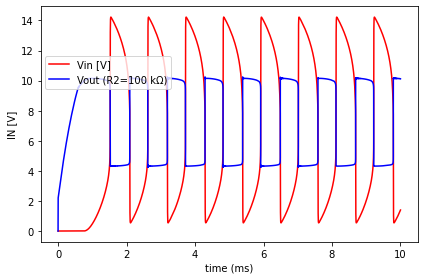

In [25]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])
circuit.include(spice_library['BC556B'])

circuit.V('1', '+5V', circuit.gnd, 'DC 15')
circuit.V('2', '+15V', circuit.gnd, 'DC 15')
circuit.V('3', '-15V', circuit.gnd, 'DC -15')
circuit.V('4', 'CV', circuit.gnd, 'DC 5')

#expo converter
circuit.R(11, 'CV', 'R11', 100@u_kΩ)
circuit.R(13, 'R11', circuit.gnd, 2@u_kΩ)
circuit.BJT('1', '-15V', 'R11', 'Q1', model="BC556B")
circuit.R(14, 'Q1', "+15V", 1@u_MΩ)
circuit.BJT('2', circuit.gnd, 'Q1', 'Q2', model="BC556B")
circuit.R(15, 'Q2', "X3i", 10@u_kΩ)


#oszillator
circuit.X('1', '4069UB', 'X1i', 'X1o', '+5V', circuit.gnd)
circuit.X('2', '4069UB', 'X1o', 'X3i', '+5V', circuit.gnd)
#circuit.R(3, 'X2o', 'X3i', 1@u_Ω)
circuit.X('3', '4069UB', 'X3i', 'X3o', '+5V', circuit.gnd)
circuit.R(4, 'X3o', 'X4i', 100@u_kΩ)
circuit.X('4', '4069UB', 'X4i', 'X4o', '+5V', circuit.gnd)

circuit.R(1, 'X1i', 'X2o', 22@u_kΩ)
circuit.R(2, 'X1i', 'X3o', 10@u_kΩ)
circuit.R(5, 'X4i', 'X4o', 500@u_kΩ)
circuit.C(1, 'X3i', 'X3o', 2.2@u_uF)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.initial_condition(X1i=0.0)
simulator.options('savecurrents')

analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=10@u_ms)

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
#ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
#buffer_axis, = ax1_buffer.plot(u_ms(analysis['CV'].abscissa), analysis['CV'], color='Orange')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['X4o'].abscissa), analysis['X4o'], color='Red')
buffer_axis, = ax1_buffer.plot(u_ms(analysis['X3i'].abscissa), analysis['X3i'], color='Blue')
#buffer_axis, = ax1_buffer.plot(u_ms(analysis['X3o'].abscissa), u_mA(analysis['@Q2[ie]']), color='Green')
ax1_buffer.legend(('Vin [V]', 'Vout (R2=100 kΩ)', 'Vout (R2=125 kΩ)', 'Vout (R2=150 kΩ)', 'Vout (R2=200 kΩ)'), loc=(0.01,0.65))

plt.tight_layout()
plt.show()

In [10]:
from IPython.core.display import display, HTML
display(HTML('''
<div class="hero is-medium" style="background: url('{{ '/assets/cmos_buffer_files/tmb_ube_screamer.jpg' | relative_url }}') no-repeat center center; background-size: cover; background-attachment: fixed;">
   <div class="hero-body">
        <div class="content has-text-centered">
        </div>
    </div>
</div>
'''))

# references
{: class="subtitle is-lowercase"}

1. [CD4069](https://www.ti.com/lit/ds/schs054e/schs054e.pdf) Datasheet
1. [CMOS VCO](https://www.schmitzbits.de/vco4069.html) from René Schmitz 
1. [CMOS VCO](http://www5b.biglobe.ne.jp/~houshu/synth/VcoMos0212.GIF) from Osamu Hoshuyama
